<a href="https://colab.research.google.com/github/MatteoAldovardi92/Taxi_Project/blob/main/NeuralTaxiNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!pip install -q kaggle

!kaggle datasets download -d mnavas/taxi-routes-for-mexico-city-and-quito

!unzip taxi-routes-for-mexico-city-and-quito.zip



Mounted at /content/drive
Dataset URL: https://www.kaggle.com/datasets/mnavas/taxi-routes-for-mexico-city-and-quito
License(s): CC-BY-SA-4.0
Archive:  taxi-routes-for-mexico-city-and-quito.zip
  inflating: all-data_clean.csv      
  inflating: bog_clean.csv           
  inflating: mex_clean.csv           
  inflating: uio_clean.csv           


In [2]:

import pandas as pd
df = pd.read_csv('mex_clean.csv')


In [3]:
df.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'store_and_fwd_flag', 'trip_duration',
       'dist_meters', 'wait_sec'],
      dtype='object')

In [4]:
df.drop(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',  'store_and_fwd_flag'],
        axis=1, inplace=True)


In [5]:
df.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,dist_meters,wait_sec
0,-99.097369,19.416874,-99.202729,19.430353,120449,12373,242
1,-99.297148,19.322128,-99.289949,19.326538,14110,1700,461
2,-99.289603,19.326263,-99.271874,19.328530,681,2848,129
3,-99.271161,19.328875,-99.279900,19.326256,436,1409,106
4,-99.282761,19.326944,-99.291705,19.322754,442,1567,85


In [6]:
#Preparation of the dataset:
X = df.drop('trip_duration', axis=1)
y = df['trip_duration']

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

n_hidden = 10


In [9]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


model = nn.Sequential(
    nn.Linear(6, n_hidden),
    nn.BatchNorm1d(n_hidden),
    nn.ReLU(),
    nn.Linear(n_hidden, 1)  # For regression or binary classification
).to(device)


Using device: cuda


In [14]:
# Move data to GPU
X_train_tensor = torch.tensor(X_train)
y_train_tensor = torch.tensor(y_train.values)
X_test_tensor = torch.tensor(X_test)
y_test_tensor = torch.tensor(y_test.values)

# Move data to GPU and ensure consistent dtype
X_train_tensor = torch.tensor(X_train, dtype=torch.float32, device=device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32, device=device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32, device=device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32, device=device)

### Training loop

In [16]:

# Model
n_features = X_train_tensor.shape[1] # This way I can easily modify the number of features
n_hidden = 10
model = nn.Sequential(
    nn.Linear(n_features, n_hidden),
    nn.BatchNorm1d(n_hidden),
    nn.ReLU(),
    nn.Linear(n_hidden, 1)
).to(device)

# Create DataLoaders
train_loader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32, device=device),
                                       torch.tensor(y_train.values, dtype=torch.float32, device=device)),
                          batch_size=32, shuffle=True)


# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Track losses
train_losses = []
val_losses = []

n_epochs = 2000000
for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        preds = model(batch_X)
        loss = criterion(preds, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation step
    model.eval()
    with torch.no_grad():
        val_preds = model(X_test_tensor)
        val_loss = criterion(val_preds, y_test_tensor).item()
        val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{n_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

Epoch 1/2000000 | Train Loss: 31929232375.7539 | Val Loss: 137622634496.0000
Epoch 2/2000000 | Train Loss: 32011880039.9756 | Val Loss: 137622536192.0000
Epoch 3/2000000 | Train Loss: 31929709500.2020 | Val Loss: 137622372352.0000
Epoch 4/2000000 | Train Loss: 31924954445.5908 | Val Loss: 137622126592.0000
Epoch 5/2000000 | Train Loss: 31925481891.0134 | Val Loss: 137621798912.0000
Epoch 6/2000000 | Train Loss: 31924371216.0653 | Val Loss: 137621340160.0000
Epoch 7/2000000 | Train Loss: 31924519929.3125 | Val Loss: 137620865024.0000
Epoch 8/2000000 | Train Loss: 31923518501.2036 | Val Loss: 137620307968.0000
Epoch 9/2000000 | Train Loss: 32025126623.2917 | Val Loss: 137619570688.0000
Epoch 10/2000000 | Train Loss: 31922456664.8151 | Val Loss: 137618964480.0000
Epoch 11/2000000 | Train Loss: 31923213909.2830 | Val Loss: 137618210816.0000
Epoch 12/2000000 | Train Loss: 31922988545.7429 | Val Loss: 137617326080.0000
Epoch 13/2000000 | Train Loss: 32467861184.9186 | Val Loss: 137616654336.

KeyboardInterrupt: 

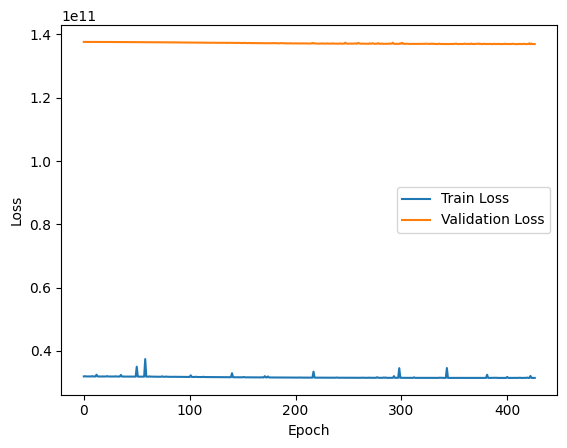

In [17]:
import matplotlib.pyplot as plt

x_axis = range(len(train_losses))
plt.plot(x_axis, train_losses, label='Train Loss')
plt.plot(x_axis, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Should I rescale $y$ as well??